# Data Science Bowl 2019 Project

The following script finds 3 features that are used to predict a child's performance on assessments within the educational app 'Measure Up' for the Data Science Bowl 2019 Kaggle Competition.  The 3 features are the total amount of time the child spent performing certain types of gameplay. The script walks through how these features are generated and how they are used in a k-Nearest Neighbors model to predict assessment performance.  


## kNN justification and considerations

I chose to use a kNN model here because kNN is pretty simple and intuitive as first pass for a small number of input features (only 3).  I also knew the number of clusters that I was looking for -- there were only 4 classes of assessment performance and this is the only hyperparameter to tune for a kNN.  Since kNN is a non-parametric algorithm, it was a safe choice since it doesn't require the features I engineered to meet any assumptions. 

One potential drawback of using the kNN on this dataset is the slight imbalance in the number of examples for each 'accuracy_group' in the training data.  Certain groups are overrepresented and this can cause a bias towards these groups, causing those groups that are underrepresented to be misclassified.  

Another drawback of using the kNN is the sensitivity to outliers.  In the game_time data there are outliers in the '0' group, that spent a lot of time in the game, but never took assessments.  This can affect the accuracy of the classification.  


## The script is organized by 7 parts:

__Training Data Set__
- Data ingestion
- Exploratory data analysis 
- Data Cleaning and Munging
- Data Visualization and statistics
- Model building and evaluation

__Test Data Set__
- Test set cleaning, munging
- Test set predictions


## Next steps / future directions (with more time):

- Parse the '0' accuracy group to see if there are subgroups in there that can be dropped due to lack of activity
- Improving the features used to predict the child's assessment performance
    - Look at the # of help events the child initiated (more help events may mean higher performance)
    - Look at the responses on games -- performance on games may predict assessment performance.
    - Look at exploration of toys in 'Activity' type gameplay.  Higher toy exploration may predict later performance
- Improve prediction model:
    - Test other classification models
    - Tune hyperparameters
    - Try boosting and / or stacking models to improve performance. 
    

In [3]:
# Import necessary packages
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.neighbors import KNeighborsClassifier 
from sklearn.model_selection import cross_val_score 

In [4]:
path = r'C:\Users\micha\Desktop\Kaggle - Data Science Bowl 2019'
os.chdir(path)

## Data ingestion

In [5]:
# Load the training data
train = pd.read_csv('train.csv')#, index_col='timestamp', parse_dates=True) #,usecols=keep_cols)
train_labels = pd.read_csv('train_labels.csv')

# Keep only the following columns in the test set to save RAM on the Kaggle Kernel
keep_cols1 = ['installation_id','world','timestamp','type','game_time','game_session',]

# Load the test data
test = pd.read_csv('test.csv', usecols=keep_cols1) # nrows =100000

In [41]:
print('Size of train data', train.shape)
print('Size of train_labels data', train_labels.shape)
print('Size of test data', test.shape)

Size of train data (11341042, 11)
Size of train_labels data (17690, 7)
Size of test data (1156414, 6)


In [56]:
train_labels['accuracy_group'].value_counts()

3    8845
0    4229
1    2411
2    2205
Name: accuracy_group, dtype: int64

In [42]:
## Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [45]:
%%time
## Reduce memory usage of loaded variables
train = reduce_mem_usage(train)
train_labels = reduce_mem_usage(train_labels)
test = reduce_mem_usage(test)

Mem. usage decreased to 778.73 Mb (0.0% reduction)
Mem. usage decreased to  0.49 Mb (0.0% reduction)
Mem. usage decreased to 48.53 Mb (8.3% reduction)
Wall time: 228 ms


## Exploratory data analysis

In [47]:
train.info()
train_labels.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11341042 entries, 0 to 11341041
Data columns (total 11 columns):
event_id           object
game_session       object
timestamp          object
event_data         object
installation_id    object
event_count        int16
event_code         int16
game_time          int32
title              object
type               object
world              object
dtypes: int16(2), int32(1), object(8)
memory usage: 778.7+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17690 entries, 0 to 17689
Data columns (total 7 columns):
game_session       17690 non-null object
installation_id    17690 non-null object
title              17690 non-null object
num_correct        17690 non-null int8
num_incorrect      17690 non-null int8
accuracy           17690 non-null float16
accuracy_group     17690 non-null int8
dtypes: float16(1), int8(3), object(3)
memory usage: 501.1+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1156414 entries, 0 to 1156413
Data co

In [48]:
# Explore data and see if there are any out of place values, missing values etc.
display(test['type'].value_counts())
display(test['installation_id'].value_counts())
display(test['world'].value_counts())

Game          572260
Activity      466274
Assessment    102627
Clip           15253
Name: type, dtype: int64

7b728c89    21237
5a6f3de8    18279
090fe325    13758
77d5414c    13231
ce08e98b    12416
            ...  
51bc6b81        1
d1e3bd8c        1
c683651f        1
af147c52        1
c2cfee57        1
Name: installation_id, Length: 1000, dtype: int64

MAGMAPEAK       511291
TREETOPCITY     332295
CRYSTALCAVES    311387
NONE              1441
Name: world, dtype: int64

In [49]:
# Check for missing data
assert pd.notna(train).all().all()
assert pd.notna(train_labels).all().all()
assert pd.notna(test).all().all()
print('No missing data')

No missing data


## Data Cleaning and Munging

In [52]:
# Merge train_labels info with event data info to look at accuracy groups with respect to
# different event info
train_order = pd.merge_ordered(left = train, right = train_labels, 
                 on = ['installation_id','game_session'], how='left')

### Observe the now merged tables, with the label data in the rightmost columns

In [7]:
train_order.head(5)

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title_x,type,world,title_y,num_correct,num_incorrect,accuracy,accuracy_group
0,27253bdc,04168b61c0650977,2019-09-06T18:18:42.392Z,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Ordering Spheres,Clip,TREETOPCITY,NaN,NaN,NaN,NaN,NaN
1,51311d7a,07bacda7f9437b38,2019-09-06T18:11:28.381Z,"{""version"":""1.0"",""round"":0,""event_count"":1,""ga...",0001e90f,1,2000,0,Dino Drink,Game,MAGMAPEAK,NaN,NaN,NaN,NaN,NaN
2,5be391b5,07bacda7f9437b38,2019-09-06T18:11:38.858Z,"{""coordinates"":{""x"":827,""y"":331,""stage_width"":...",0001e90f,2,4010,10502,Dino Drink,Game,MAGMAPEAK,NaN,NaN,NaN,NaN,NaN
3,c6971acf,07bacda7f9437b38,2019-09-06T18:11:40.967Z,"{""round"":0,""event_count"":3,""game_time"":12552,""...",0001e90f,3,2060,12552,Dino Drink,Game,MAGMAPEAK,NaN,NaN,NaN,NaN,NaN
4,a29c5338,07bacda7f9437b38,2019-09-06T18:11:40.970Z,"{""description"":""Our competitors are getting th...",0001e90f,4,3010,12552,Dino Drink,Game,MAGMAPEAK,NaN,NaN,NaN,NaN,NaN


In [53]:
### Fill in missing accuracy group values for all events and
### set index to variables that dataframe will be grouped by
# First set index and sort chronologically within an 
#   [installation_id, world] pair with timestamp in index
train_time = train_order.set_index(['installation_id','world','timestamp'])

# Delete the train_order object to conserve RAM 
del train_order

train_time = train_time.sort_index()

# Backfill NaN values of events around assessments, bounded by installation_id and world 
train_time = train_time.groupby(level=['installation_id','world']).bfill()


### Observe the multi-index and backfilled NaN values -- these can be seen in the accuracy group column and other assessment metric columns that now have non-NaN values in rows that are not associated with assessments (i.e. gameplay classification can be seen by looking at the value in the 'type' column).  

In [54]:
train_time.dropna().head()

event_id  \
installation_id world       timestamp                            
0006a69f        TREETOPCITY 2019-08-06T05:07:33.207Z  27253bdc   
                            2019-08-06T05:07:58.484Z  27253bdc   
                            2019-08-06T05:09:10.506Z  b7dc8128   
                            2019-08-06T05:09:13.298Z  4b5efe37   
                            2019-08-06T05:09:14.934Z  2c4e6db0   

                                                          game_session  \
installation_id world       timestamp                                    
0006a69f        TREETOPCITY 2019-08-06T05:07:33.207Z  d3ffed2d2d77597d   
                            2019-08-06T05:07:58.484Z  e882eb6760063bb1   
                            2019-08-06T05:09:10.506Z  75e40170dea0bd21   
                            2019-08-06T05:09:13.298Z  75e40170dea0bd21   
                            2019-08-06T05:09:14.934Z  75e40170dea0bd21   

                                                                                             event_data  \
installation_id world       timestamp                                                                     
0006a69f        TREETOPCITY 2019-08-06T05:07:33.207Z             {"event_code": 2000, "event_count": 1}   
                            2019-08-06T05:07:58.484Z             {"event_code": 2000, "event_count": 1}   
                            2019-08-06T05:09:10.506Z  {"version":"1.0","round":0,"event_count":1,"ga...   
                            2019-08-06T05:09:13.298Z  {"coordinates":{"x":449,"y":637,"stage_width":...   
                            2019-08-06T05:09:14.934Z  {"houses":[4,3,2],"dinosaurs":[{"name":"don","...   

                                                      event_count  event_code  \
installation_id world       timestamp                                           
0006a69f        TREETOPCITY 2019-08-06T05:07:33.207Z            1        2000   
                            2019-08-06T05:07:58.484Z            1        2000   
                            2019-08-06T05:09:10.506Z            1        2000   
                            2019-08-06T05:09:13.298Z            2        4010   
                            2019-08-06T05:09:14.934Z            3        2020   

                                                      game_time  \
installation_id world       timestamp                             
0006a69f        TREETOPCITY 2019-08-06T05:07:33.207Z          0   
                            2019-08-06T05:07:58.484Z          0   
                            2019-08-06T05:09:10.506Z          0   
                            2019-08-06T05:09:13.298Z       2810   
                            2019-08-06T05:09:14.934Z       4443   

                                                                      title_x  \
installation_id world       timestamp                                           
0006a69f        TREETOPCITY 2019-08-06T05:07:33.207Z  Tree Top City - Level 1   
                            2019-08-06T05:07:58.484Z         Ordering Spheres   
                            2019-08-06T05:09:10.506Z         All Star Sorting   
                            2019-08-06T05:09:13.298Z         All Star Sorting   
                            2019-08-06T05:09:14.934Z         All Star Sorting   

                                                      type  \
installation_id world       timestamp                        
0006a69f        TREETOPCITY 2019-08-06T05:07:33.207Z  Clip   
                            2019-08-06T05:07:58.484Z  Clip   
                            2019-08-06T05:09:10.506Z  Game   
                            2019-08-06T05:09:13.298Z  Game   
                            2019-08-06T05:09:14.934Z  Game   

                                                                           title_y  \
installation_id world       timestamp                                                
0006a69f        TREETOPCITY 2019-08-06T05:07:33.207Z  Mushroom Sorter (Assessment)   
                       

In [10]:
# # 'Clip' type activties don't have a gametime, so we need to fill in a time.  Assume about 2min / clip.
train_time_clips = train_time[train_time['type'] == 'Clip'].replace(0,120000)['game_time']
train_time.loc[train_time['type'] == 'Clip','game_time'] = train_time_clips 

### Observe the Clip game_time with 0 replaced by 120000

In [12]:
train_time.loc[train_time['type'] == 'Clip',:].head()

event_id  \
installation_id world       timestamp                            
0001e90f        MAGMAPEAK   2019-09-06T17:54:17.519Z  27253bdc   
                            2019-09-06T18:10:51.183Z  27253bdc   
                NONE        2019-09-06T17:53:46.937Z  27253bdc   
                TREETOPCITY 2019-09-06T18:18:11.250Z  27253bdc   
                            2019-09-06T18:18:42.392Z  27253bdc   

                                                          game_session  \
installation_id world       timestamp                                    
0001e90f        MAGMAPEAK   2019-09-06T17:54:17.519Z  17eeb7f223665f53   
                            2019-09-06T18:10:51.183Z  091587ed87b9637c   
                NONE        2019-09-06T17:53:46.937Z  45bb1e1b6b50c07b   
                TREETOPCITY 2019-09-06T18:18:11.250Z  3fce4f09769ff0b7   
                            2019-09-06T18:18:42.392Z  04168b61c0650977   

                                                                                  event_data  \
installation_id world       timestamp                                                          
0001e90f        MAGMAPEAK   2019-09-06T17:54:17.519Z  {"event_code": 2000, "event_count": 1}   
                            2019-09-06T18:10:51.183Z  {"event_code": 2000, "event_count": 1}   
                NONE        2019-09-06T17:53:46.937Z  {"event_code": 2000, "event_count": 1}   
                TREETOPCITY 2019-09-06T18:18:11.250Z  {"event_code": 2000, "event_count": 1}   
                            2019-09-06T18:18:42.392Z  {"event_code": 2000, "event_count": 1}   

                                                      event_count  event_code  \
installation_id world       timestamp                                           
0001e90f        MAGMAPEAK   2019-09-06T17:54:17.519Z            1        2000   
                            2019-09-06T18:10:51.183Z            1        2000   
                NONE        2019-09-06T17:53:46.937Z            1        2000   
                TREETOPCITY 2019-09-06T18:18:11.250Z            1        2000   
                            2019-09-06T18:18:42.392Z            1        2000   

                                                      game_time  \
installation_id world       timestamp                             
0001e90f        MAGMAPEAK   2019-09-06T17:54:17.519Z     120000   
                            2019-09-06T18:10:51.183Z     120000   
                NONE        2019-09-06T17:53:46.937Z     120000   
                TREETOPCITY 2019-09-06T18:18:11.250Z     120000   
                            2019-09-06T18:18:42.392Z     120000   

                                                                      title_x  \
installation_id world       timestamp                                           
0001e90f        MAGMAPEAK   2019-09-06T17:54:17.519Z     Magma Peak - Level 1   
                            2019-09-06T18:10:51.183Z     Magma Peak - Level 2   
                NONE        2019-09-06T17:53:46.937Z  Welcome to Lost Lagoon!   
                TREETOPCITY 2019-09-06T18:18:11.250Z  Tree Top City - Level 1   
                            2019-09-06T18:18:42.392Z         Ordering Spheres   

                                                      type title_y  \
installation_id world       timestamp                                
0001e90f        MAGMAPEAK   2019-09-06T17:54:17.519Z  Clip     NaN   
                            2019-09-06T18:10:51.183Z  Clip     NaN   
                NONE        2019-09-06T17:53:46.937Z  Clip     NaN   
                TREETOPCITY 2019-09-06T18:18:11.250Z  Clip     NaN   
                            2019-09-06T18:18:42.392Z  Clip     NaN   

                                                      num_correct  \
installation_id world       timestamp                               
0001e90f        MAGMAPEAK   2019-09-06T17:54:17.519Z          NaN   
                            2019-09-06T18:10:51.183Z          NaN   
                NONE      

In [14]:
# Then fill the rest of the events with 0 for those events 
# not associated with installation_ids or game_sessions where an assessment took place.  
train_time = train_time.fillna(0)

# Add accuracy_group and type to index so you can do a multi-level sort
train_time = train_time.set_index(['game_session','accuracy_group','type'],append=True) # ,'assessment_id'


### Observe that game_time resets to zero and the game_session takes on a new value as the child moves from one type of activity to the next.

In [41]:
train_time.iloc[355:365,[0,4]]

event_id  \
installation_id world     timestamp                game_session     accuracy_group type                 
0001e90f        MAGMAPEAK 2019-09-06T17:59:35.809Z a1ec58f109218255 0.0            Activity  9ee1c98c   
                          2019-09-06T17:59:36.365Z a1ec58f109218255 0.0            Activity  5e812b27   
                          2019-09-06T17:59:37.466Z a1ec58f109218255 0.0            Activity  1bb5fbdb   
                          2019-09-06T17:59:38.533Z a1ec58f109218255 0.0            Activity  84538528   
                          2019-09-06T17:59:38.535Z a1ec58f109218255 0.0            Activity  b2dba42b   
                          2019-09-06T17:59:39.746Z a1ec58f109218255 0.0            Activity  1bb5fbdb   
                          2019-09-06T18:00:51.915Z f11eb823348bfa23 0.0            Game      6d90d394   
                          2019-09-06T18:00:56.121Z f11eb823348bfa23 0.0            Game      7040c096   
                          2019-09-06T18:00:57.986Z f11eb823348bfa23 0.0            Game      5a848010   
                          2019-09-06T18:01:11.792Z f11eb823348bfa23 0.0            Game      4a09ace1   

                                                                                             game_time  
installation_id world     timestamp                game_session     accuracy_group type                 
0001e90f        MAGMAPEAK 2019-09-06T17:59:35.809Z a1ec58f109218255 0.0            Activity      67767  
                          2019-09-06T17:59:36.365Z a1ec58f109218255 0.0            Activity      68317  
                          2019-09-06T17:59:37.466Z a1ec58f109218255 0.0            Activity      69434  
                          2019-09-06T17:59:38.533Z a1ec58f109218255 0.0            Activity      70501  
                          2019-09-06T17:59:38.535Z a1ec58f109218255 0.0            Activity      70501  
                          2019-09-06T17:59:39.746Z a1ec58f109218255 0.0            Activity      71717  
                          2019-09-06T18:00:51.915Z f11eb823348bfa23 0.0            Game              0  
                          2019-09-06T18:00:56.121Z f11eb823348bfa23 0.0            Game           4205  
                          2019-09-06T18:00:57.986Z f11eb823348bfa23 0.0            Game           6057  
                          2019-09-06T18:01:11.792Z f11eb823348bfa23 0.0            Game          19873

### Given that game_time resets to zero after each type of activity, we will want to get the last game_time associated with each type of activity.  This is done in the step below.

In [42]:
 # Auto-dispatch the sum aggregation on multi-level group using the groupby method
# Essentially sum the amount of time for each type of gameplay for a particular installation_id ->
# world -> accuracy_group -> type of event to get an estimate of time spent in 
# each type of activity
train_time_agg = train_time.groupby( \
                 level=['installation_id','world','game_session']).last()['game_time']

In [43]:
# Now aggregate these game times to get a sum for each type of activity
train_time_agg = train_time['game_time'].groupby(level=['installation_id','world',\
                                                        'type','accuracy_group'])\
                                                        .agg(game_time='sum')

### Observe the total game_time for each type of activity prior to an assessment within each [installation_id, world] pair

In [53]:
train_time_agg.head()

game_time
installation_id world       type     accuracy_group             
0001e90f        MAGMAPEAK   Activity 0.0              29719158.0
                            Clip     0.0                240000.0
                            Game     0.0             244106886.0
                NONE        Clip     0.0                120000.0
                TREETOPCITY Clip     0.0                240000.0

#### Further data munging below to prepare the data set to be fit to a kNN-model. 

In [44]:
# Now unstack the type column to get counts for each type of activity within each 
# [installation_id, world] pair
train_time = train_time_agg.unstack('type')

# Fill all those gameplay times that are empty with zeros so that the next step,
# the cumulative sum below, executes correctly. 
train_time = train_time.fillna(0)

# Calculate the cumulative sum of game time at assessment time in each type of gameplay for each 
# [installation_id world] pair
train_time = train_time['game_time'].groupby(level=['installation_id','world'])\
                                        .transform(pd.DataFrame.cumsum)

# Delete the train_time_agg object to conserve RAM on the Kaggle kernel
del train_time_agg

# Fill all [installation_id, world] rows that are missing an activity count with zeros
train_time = train_time.fillna(0)

# Now move the accuracy group out of the index to look at 
# correlation with type of activity counts
train_time.reset_index(level=2, inplace=True)

## Data Visualization and Statistics

C:\Users\micha\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\micha\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


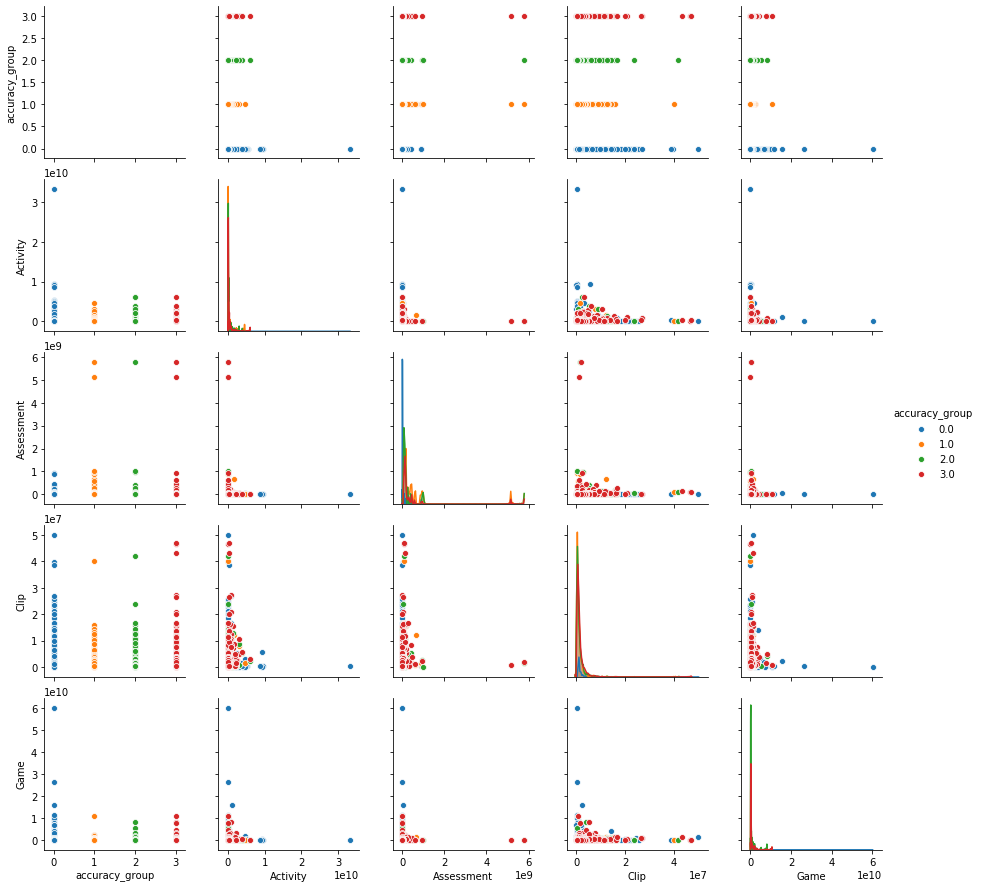

In [55]:
# Now look at the time spent in each type of gameplay separated by 
# accuracy_group.  
sns.pairplot(train_time,
             kind="scatter", 
             hue='accuracy_group')

### The plot above shows a clear relationship between the cumulative amount of time spent on Activity and Clip type gameplays and the accuracy group of the child on the assessment.  Let's quantify this by performing a correlation.  

In [56]:
# Based on the plots above, let's quantify this relationship with a correlation. 
train_corr = train_time.corr()[['accuracy_group']]
display(train_corr)

type,accuracy_group
type,
accuracy_group,1.000000
Activity,0.065569
Assessment,0.056354
Clip,0.261809
Game,0.064370


### As expected, both Activity and Clip cumulative gameplay time are correlated with the accuracy_group.  Let's now build a model using these features and see how we do.

# Model fitting and evaluation

In [45]:
# Time to build models with the gameplay time features

# Create arrays for the features and the response variable
y = train_time['accuracy_group'].values
X = train_time.drop(['accuracy_group','Assessment'], axis=1).values

del train_time

In [46]:
# Create a k-NN classifier with 4 neighbors, one for each accuracy_group
knn = KNeighborsClassifier(n_neighbors=4)

# Fit the classifier to the data
knn.fit(X, y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='uniform')

In [47]:
# Now evaluate the knn-Model 

# Print the accuracy
print(knn.score(X, y))

y_pred = knn.predict(X)

cv_scores = cross_val_score(knn, X, y, cv = 5)

# Print the 5-fold cross-validation scores
print(cv_scores)

print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))            

0.869895386319141
[0.83438798 0.83112517 0.83409136 0.83605261 0.83395965]
Average 5-Fold CV Score: 0.8339233532115753


0.869895386319141

### Here we see that with just 3 features of cumulative gameplay time in each type of activity (excluding assessment time), we can get approximately ~83% accuracy in predicting the child's performance on assessments.  

#### The remainder of the code below is for the kaggle competition submission.  This includes saving the kNN model and generating predictions for the test set.

In [ ]:
knnPickle = open('knn_pickle_file', 'wb') 

# source, destination 
pickle.dump(knn, knnPickle)  

# load the model from disk
knn = pickle.load(open('knn_pickle_file', 'rb'))

## Test set munging and cleaning

In [62]:
# Now format and process the test set to make predictions

### Fill in missing accuracy group values for all events and
### set index to variables that dataframe will be grouped by
# First set index and sort chronologically within an 
#   [installation_id, world] pair with timestamp in index
test_time = test.set_index(['installation_id','world','timestamp'])

# Add a column, 'assessment_id', that keeps track of assessment 
# chronologically for each installation_id
test_time.loc[test_time['type']=='Assessment','assessment_id'] = \
                                               range(1,len(test_time[test_time['type']=='Assessment'])+1)

# del test

test_time = test_time.sort_index()

# Backfill NaN values of events that took place before assessments, these
# will be the events that impacted performance on those assessments.
test_time = test_time.groupby(level=['installation_id','world']).bfill()

# # 'Clip' type activities don't have a gametime, so we need to fill in a time.  Assume about 2min / clip.
test_time_clips = test_time[test_time['type'] == 'Clip'].replace(0,120000)['game_time']
test_time.loc[test_time['type'] == 'Clip','game_time'] = test_time_clips 

# Then fill the rest of the events with 0 for those events 
# not associated with installation_ids or game_sessions where an assessment took place.  
test_time = test_time.fillna(0)

# Add accuracy_group and type to index so you can do a multi-level sort
test_time = test_time.set_index(['game_session','assessment_id','type'],append=True)

# Auto-dispatch the sum aggregation on multi-level group using the groupby method
# Essentially sum the amount of time for each type of gameplay for a particular installation_id ->
# world -> accuracy_group -> type of event to get an estimate of time spent in 
# each type of activity
test_time_agg = test_time.groupby(level=['installation_id','world','assessment_id','game_session'])\
                .last()['game_time']


test_time_agg = test_time['game_time'].groupby(level=['installation_id','world','assessment_id','type'])\
                                      .agg(game_time='sum')


# Now unstack the type column to get counts for each type of activity with each 
# [installation_id, world] pair
test_time = test_time_agg.unstack('type')
del test_time_agg

# Fill all [installation_id, world] rows that are missing an activity count with zeros
test_time = test_time.fillna(0)

test_time = test_time['game_time'].groupby(level=['installation_id','world'])\
                                        .transform(pd.DataFrame.cumsum)


## Test set predictions

In [63]:
# Create arrays for the features and the response variable
# X_final = test_time_scale.drop(['Assessment'], axis=1).values
X_final = test_time.drop(['Assessment'], axis=1).values

y_pred = knn.predict(X_final)

# Coerce the predictions to ints since this is required for a 
# correct submission format.
y_pred = y_pred.astype('int')

In [64]:
# Put features and response variable into dataframe to be written to csv
sub = pd.DataFrame({'installation_id':test_time.index.get_level_values(0).values, 
                    'accuracy_group':y_pred})
                                         
# Pick the last assessment score for each installation_id    
sub = sub.groupby('installation_id').last()

# Move installation_id out of the index as required
# for the correct submission format.
sub.reset_index(inplace=True)

# Write to csv
sub.to_csv('submission.csv', index = False)